In [1]:
# !pip install matplotlib
!pip install tqdm

In [2]:
import matplotlib.pyplot as plt

from glob import glob
import pandas as pd
import os
from tqdm import tqdm as tqdm 
from IPython.display import Image
from pathlib import Path
import json
import numpy as np

/afs/csail.mit.edu/u/c/czw/.config/matplotlib is not a writable directory
Matplotlib created a temporary cache directory at /tmp/matplotlib-fpbs6bbz because there was an issue with the default path (/afs/csail.mit.edu/u/c/czw/.config/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
# results_root = "/storage/czw/linear_voltage_single_electrode_SS_SM_prototype/linear_voltage_single_electrode"
results_root = "/storage/czw/btbench/single_electrode_btbench_full/eval_results_full_SS_SM/linear_voltage_single_electrode"


In [4]:
def get_test_results(results, eval_name):
    eval_results = results["evaluation_results"]
    assert len(eval_results.keys()) == 1
    records = []
    for subject_trial in eval_results:
        subject = subject_trial.split("_")[0][len("btbank"):]
        trial = subject_trial.split("_")[1]
        subject_trial_results = eval_results[subject_trial]['electrode']
        for electrode in subject_trial_results:
            electrode_results = subject_trial_results[electrode]
            time_bin_results = electrode_results["time_bins"]
            for time_bin in time_bin_results:
                time_bin_start = time_bin['time_bin_start']
                fold_results = time_bin['folds']
                avg_test = np.mean([f['test_roc_auc'] for f in fold_results])
                records.append({
                    "subject": subject,
                    "trial": trial,
                    "ID": f'{electrode}-sub_{subject}',
                    "electrode": electrode,
                    "avg_test": avg_test,
                    "time_bin": time_bin_start,
                    "task": eval_name
                })
        return records

In [5]:
all_records = []
all_results_paths = glob(os.path.join(results_root, "*"))
for path in tqdm(all_results_paths):
    name = Path(path).stem
    sub_id = name.split("_")[1][len("btbank"):]
    trial_id = name.split("_")[2]
    eval_name = "_".join(name.split("_")[3:])
    with open(path, "r") as f:
        results = json.load(f)
        test_results = get_test_results(results, eval_name)
    all_records += test_results
results_df = pd.DataFrame.from_records(all_records)

100%|██████████████████████████████████████████████████████████████████████████████████| 494/494 [00:28<00:00, 17.22it/s]


In [6]:
#https://bookdown.org/u0243256/tbicc/freesurfer.html
dk2text_d = {'supramarginal': 'supramarginal',
             'postcentral': 'postcentral',
             'medialorbitofrontal': 'medial orbitofrontal',
             'caudalmiddlefrontal': 'caudal middle frontal',
             'posteriorcingulate': 'posterior cingulate',
             'middletemporal': 'middle temporal',
             'superiortemporal': 'superior temporal',
             'bankssts': 'Banks of sup. temp. sul.',
             'superiorparietal': 'superior parietal',
             'precuneus': 'precuneus',
             'entorhinal': 'entorhinal',
             'parstriangularis': 'pars triangularis',
             'precentral': 'precentral',
             'parsorbitalis': 'pars orbitalis',
             'insula': 'insula',
             'parahippocampal': 'parahippocampal',
             'inferiortemporal': 'inferior temporal',
             'parsopercularis': 'pars opercularis',
             'fusiform': 'fusiform',
             'transversetemporal': 'transverse temporal',
             'superiorfrontal': 'superior frontal',
             'paracentral': 'paracentral',
             'lateralorbitofrontal': 'lateral orbitofrontal',
             'caudalanteriorcingulate': 'caudal anterior cingulate',
             'inferiorparietal': 'inferior parietal',
             'rostralanteriorcingulate': 'rostral anterior cingulate',
             'isthmuscingulate': 'isthmus cingulate',
             'temporalpole': 'temporal pole',
             'rostralmiddlefrontal': 'rostral middle frontal',
             'amygdala': 'Amygdala',
             'hippocampus': 'Hippocampus',
             'inf-lat-vent': 'inferior lateral ventrical',
             'putamen': 'putamen',
             'unknown': 'unknown'}

dk_names = ["superior frontal", "rostral middle frontal", "caudal middle frontal", "pars opercularis",
           "pars triangularis", "pars orbitalis", "lateral orbitofrontal", "medial orbitofrontal",
           "precentral", "paracentral", "frontal pole", "superior parietal", "inferior parietal",
           "supramarginal", "postcentral", "precuneus", "superior temporal", "middle temporal",
           "inferior temporal", "bankssts", "fusiform", "transverse temporal",
           "entorhinal","temporal pole", "parahippocampal", "lateral occipital", "lingual", "cuneus",
           "pericalcarine","rostral anterior cingulate", "caudal anterior cingulate",
           "posterior cingulate","isthmus cingulate", "insula"]

region_ids = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6]
name2region_id = {n:x for x,n in zip(region_ids, dk_names)}
region_id2region_name = {x+1:n for x,n in enumerate(["Frontal", "Parietal", "Temporal", "Occipital", "Cingulate", "Insula"])}

def dk2text(label):
    l = label.replace('ctx-','')
    l = l.replace('rh-','')
    l = l.replace('lh-','')
    l = l.replace('Left-','')
    l = l.replace('Right-','')
    l = l.lower()
    return dk2text_d[l]

def dk2region(label):
    dk_name = dk2text(label)
    if dk_name in name2region_id:
        return region_id2region_name[name2region_id[dk_name]]
    return dk_name

In [7]:
all_localization_dfs = []
braintreebank_root = "/storage/czw/braintreebank_data/"
for fpath in glob(os.path.join(braintreebank_root, "localization/sub_*/depth-wm.csv")):
    sub_localization_df = pd.read_csv(fpath)
    sub_localization_df["Subject"] = subject = os.path.dirname(fpath).split("/")[-1]
    all_localization_dfs.append(sub_localization_df)
all_localization_df = pd.concat(all_localization_dfs)

all_localization_df["region_common_name"] = [dk2region(x) for x in all_localization_df.DesikanKilliany]
all_localization_df["common_name"] = [dk2text(x) for x in all_localization_df.DesikanKilliany]
all_localization_df["Hemisphere"] = [0 if '-lh-' in x else 1 for x in all_localization_df.DesikanKilliany]

In [8]:
all_localization_df["ID"] = all_localization_df.Electrode + "-" + all_localization_df.Subject
localization_merged_df = pd.merge(results_df, all_localization_df, on="ID", how="left")

In [23]:
task_order =  ['onset', 'speech', 'volume', 'pitch', 'speaker', 'delta_volume', 'delta_pitch', 'gpt2_surprisal', 'word_length', 'word_gap', 'word_index', 'word_head_pos', 'word_part_speech', 'frame_brightness', 'global_flow', 'local_flow', 'global_flow_angle', 'local_flow_angle', 'face_num']

In [10]:
from nilearn.datasets import (
    fetch_atlas_surf_destrieux,
    load_fsaverage,
    load_fsaverage_data,
)
from nilearn.surface import SurfaceImage

fsaverage = load_fsaverage("fsaverage5")
destrieux = fetch_atlas_surf_destrieux(data_dir="/storage/czw/nilearn_data")
destrieux_atlas = SurfaceImage(
    mesh=fsaverage["pial"],
    data={
        "left": destrieux["map_left"],
        "right": destrieux["map_right"],
    },
)

# The parcellation is already loaded into memory
left_parcellation = destrieux['map_left']
right_parcellation = destrieux['map_right']


# The labels are stored as bytes for the Destrieux atlas.
# For convenience we decode them to string.
labels = [x.decode("utf-8") for x in destrieux.labels]

# Retrieve fsaverage5 surface dataset for the plotting background.
# It contains the surface template as pial and inflated version.
fsaverage_meshes = load_fsaverage()

# The fsaverage meshes contains the FileMesh objects:
print(f"{fsaverage_meshes['pial'].parts['left']=}")
print(f"{fsaverage_meshes['inflated'].parts['left']=}")

# The fsaverage data contains file names pointing to the file locations
# The sulcal depth maps will be is used for shading.
fsaverage_sulcal = load_fsaverage_data(data_type="sulcal")
print(f"{fsaverage_sulcal=}")

[_add_readme_to_default_data_locations] Added README.md to /storage/czw/nilearn_data
[get_dataset_dir] Dataset created in /storage/czw/nilearn_data/destrieux_surface
[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/9343/lh.aparc.a2009s.annot ...
[fetch_single_file]  ...done. (0 seconds, 0 min)

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/9342/rh.aparc.a2009s.annot ...
[fetch_single_file]  ...done. (0 seconds, 0 min)

fsaverage_meshes['pial'].parts['left']=<FileMesh with 10242 vertices and 20480 faces.>
fsaverage_meshes['inflated'].parts['left']=<FileMesh with 10242 vertices and 20480 faces.>
fsaverage_sulcal=<SurfaceImage (20484,)>


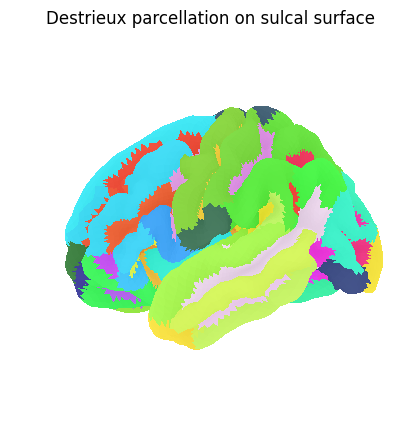

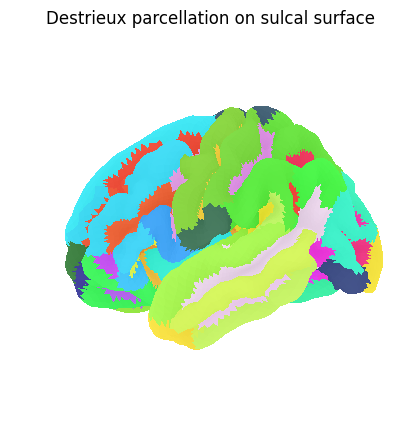

In [11]:
from nilearn.plotting import plot_surf_roi, show

plot_surf_roi(
    roi_map=destrieux_atlas,
    hemi="left",
    view="lateral",
    bg_map=fsaverage_sulcal,
    bg_on_data=True,
    darkness=0.5,
    title="Destrieux parcellation on sulcal surface",
)

In [12]:
# labels

In [13]:
# !pip uninstall nilearn

In [14]:
!which python

/storage/czw/anaconda3/envs/nilearn/bin/python


In [15]:
fsaverage_meshes['pial']

In [163]:
def get_parcellation(region_results, parcellation):
    labels = destrieux["labels"]
    results_parcellation = parcellation.copy()
    results_parcellation = np.zeros(parcellation.shape)
    for i, label in enumerate(labels):
        region_value = 0    
        region = label.decode("UTF-8")
        # print(region in region_results.index)
        if region in region_results.index:
            region_value = region_results.loc[region]['avg_test']
            results_parcellation[parcellation==i] = region_value
#             results_parcellation[parcellation==i] = 1.0 #TODO
    #         print(results_parcellation[parcellation==i])
#         if region=="G_temp_sup-Lateral":#TODO
#             results_parcellation[parcellation==i] = 0.5 #TODO
#             print("ayy", i)
        # if region=="S_temporal_sup":#TODO
        #     results_parcellation[parcellation==i] = 1 #TODO
        #     print("ayy", i)
    return results_parcellation

In [17]:
# localization_merged_df

In [18]:
# left_task_results

In [19]:
task_name_mapping = {
        'onset': 'Sentence Onset',
        'speech': 'Speech',
        'volume': 'Volume', 
        'pitch': 'Pitch',
        'speaker': 'Speaker Identity',
        'delta_volume': 'Delta Volume',
        'delta_pitch': 'Delta Pitch',
        'gpt2_surprisal': 'GPT-2 Surprisal',
        'word_length': 'Word Length',
        'word_gap': 'Inter-word Gap',
        'word_index': 'Word Position',
        'word_head_pos': 'Head Word Position',
        'word_part_speech': 'Part of Speech',
        'frame_brightness': 'Frame Brightness',
        'global_flow': 'Global Optical Flow',
        'local_flow': 'Local Optical Flow',
        'global_flow_angle': 'Global Flow Angle',
        'local_flow_angle': 'Local Flow Angle',
        'face_num': 'Number of Faces',
    }

left max: 0.8608777838191765
right max: 0.6403439826026908


NameError: name 'i' is not defined

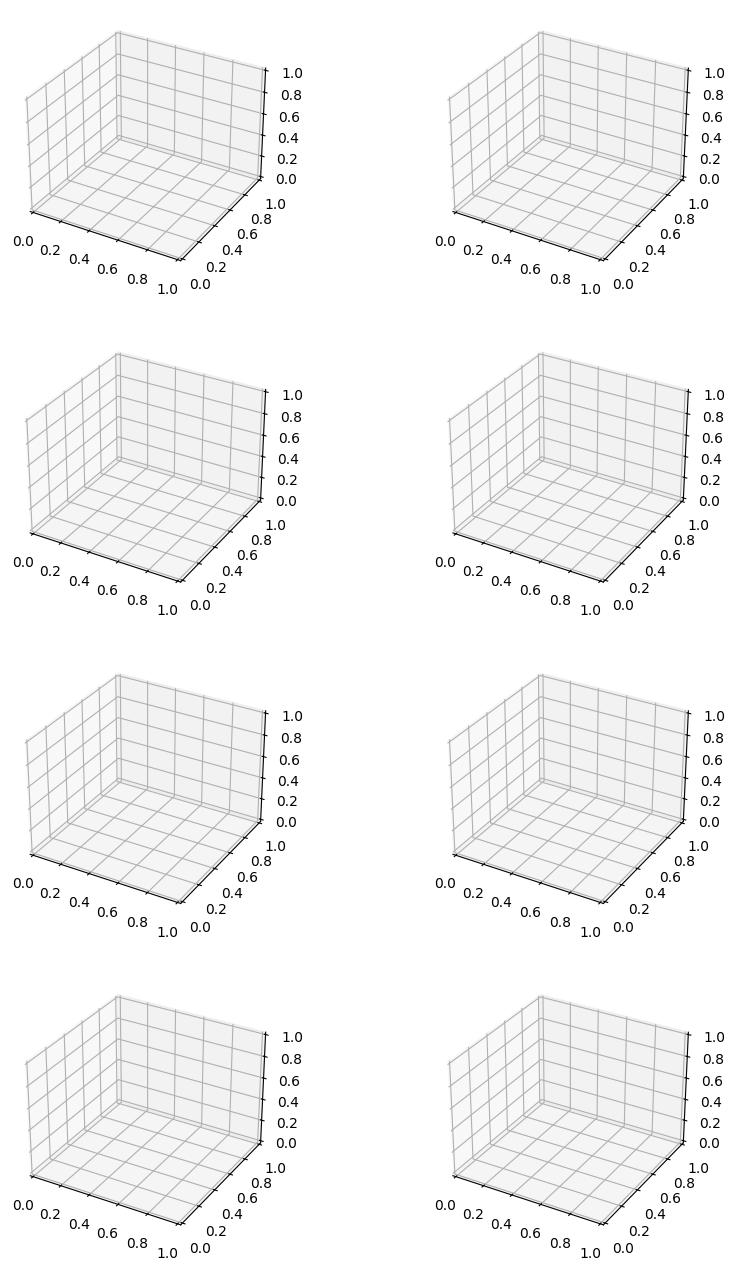

In [20]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10,4*4), subplot_kw={'projection': '3d'})

task = "onset"
task_results = localization_merged_df[localization_merged_df.task==task]
# task_results = get_task_results(task)
## Drop the regions that have less than 2 electrodes
left_task_results = task_results[task_results.Hemisphere==0]
right_task_results = task_results[task_results.Hemisphere==1]
left_task_results = left_task_results[left_task_results.groupby("Destrieux").Destrieux.transform('count') > 0]
right_task_results = right_task_results[right_task_results.groupby("Destrieux").Destrieux.transform('count') > 0]
region_results_left = left_task_results[["Hemisphere", "Destrieux", "avg_test"]].groupby("Destrieux").quantile(q=0.90)
region_results_left.index = [x[len("ctx_lh_"):] if "_lh_" in x else x for x in region_results_left.index ]
region_results_right = right_task_results[["Hemisphere", "Destrieux", "avg_test"]].groupby("Destrieux").quantile(q=0.90)
region_results_right.index = [x[len("ctx_lh_"):] if "_rh_" in x else x for x in region_results_right.index ]

# if (task == "word_onset") or (task == "sentence_onset"): 
#     print(task)
#     display(region_results_left.sort_values("value", ascending=False).head(10))
    # region_results_left = region_results_left.reset_index()
    # region_results_left[region_results_left["Destrieux"]== "S_circular_insula_ant"]["value"] = 0.99
left_results_parcellation = get_parcellation(region_results_left, left_parcellation)
right_results_parcellation = get_parcellation(region_results_right, right_parcellation)

print("left max:", left_results_parcellation.max())
print("right max:", right_results_parcellation.max())
max_avg = (left_results_parcellation.max() + right_results_parcellation.max()) / 2
max_all = max(left_results_parcellation.max(), right_results_parcellation.max())

plot_surf_roi(fsaverage['inflated'], roi_map=left_results_parcellation,
                    hemi='left', view='lateral',
                    bg_map=fsaverage_sulcal, bg_on_data=True,
                    darkness=.5, cmap="Reds", vmin=0.48, vmax=0.6,
                    # darkness=.5, cmap="Reds",
                    axes=ax[i][0])

plot_surf_roi(fsaverage['inflated'], roi_map=right_results_parcellation,
                    hemi='right', view='lateral',
                    bg_map=fsaverage_sulcal, bg_on_data=True,
                    darkness=.5, cmap="Reds", vmin=0.48, vmax=0.6,
                    # darkness=.5, cmap="Reds",
                    axes=ax[i][1])
ax[i][0].set_title(f"Task {task}")
fig.tight_layout()
plt.show()


In [ ]:
left_results_parcellation

In [ ]:
region_results_left.index = [x[len("ctx_lh_"):] for x in region_results_left.index]

In [ ]:
region_results_left

In [ ]:
fsaverage_sulcal

In [ ]:
labels

In [ ]:
region_results_right

In [ ]:
left_task_results[["Hemisphere", "Destrieux", "avg_test"]].groupby("Destrieux")

In [ ]:
task_order =  ['onset', 'speech', 'volume', 'pitch', 'speaker', 'delta_volume', 'delta_pitch', 'gpt2_surprisal', 'word_length', 'word_gap', 'word_index', 'word_head_pos', 'word_part_speech', 'frame_brightness', 'global_flow', 'local_flow', 'global_flow_angle', 'local_flow_angle', 'face_num']

In [164]:
task_results = localization_merged_df[localization_merged_df.task==task].dropna()
# task_results = get_task_results(task)
## Drop the regions that have less than 2 electrodes
left_task_results = task_results[task_results.Hemisphere==0]
right_task_results = task_results[task_results.Hemisphere==1]
left_task_results = left_task_results[left_task_results.groupby("Destrieux").Destrieux.transform('count') > 0]
right_task_results = right_task_results[right_task_results.groupby("Destrieux").Destrieux.transform('count') > 0]
region_results_left = left_task_results[["Hemisphere", "Destrieux", "avg_test"]].groupby("Destrieux").quantile(q=0.90)
region_results_left.index = [x[len("ctx_lh_"):] if "_lh_" in x else x for x in region_results_left.index ]
region_results_right = right_task_results[["Hemisphere", "Destrieux", "avg_test"]].groupby("Destrieux").quantile(q=0.90)
region_results_right.index = [x[len("ctx_lh_"):] if "_rh_" in x else x for x in region_results_right.index ]

region_results_right.loc[:,'avg_test'] = region_results_right['avg_test'].apply(scale)
region_results_left.loc[:,'avg_test'] = region_results_left['avg_test'].apply(scale)

left_results_parcellation = get_parcellation(region_results_left, left_parcellation)


In [165]:
left_results_parcellation

array([-2.67941939, -2.80599853, -2.94535568, ..., -2.70424139,
       -2.69347552, -2.69347552])

In [166]:
scale(0.48)

np.float64(-9.210340371976182)

In [167]:
from matplotlib.ticker import FuncFormatter

In [214]:
from matplotlib.colors import LinearSegmentedColormap, Normalize
grey_to_red = LinearSegmentedColormap.from_list('grey_to_red', [(0.0, 'grey'), (0.3, 'grey'), (0.4, 'yellow'), (1.0, 'red')])

def plot_task(task, axs):
    task_results = localization_merged_df[localization_merged_df.task==task].dropna()
    # task_results = get_task_results(task)
    ## Drop the regions that have less than 2 electrodes
    left_task_results = task_results[task_results.Hemisphere==0]
    right_task_results = task_results[task_results.Hemisphere==1]
    left_task_results = left_task_results[left_task_results.groupby("Destrieux").Destrieux.transform('count') > 0]
    right_task_results = right_task_results[right_task_results.groupby("Destrieux").Destrieux.transform('count') > 0]
    region_results_left = left_task_results[["Hemisphere", "Destrieux", "avg_test"]].groupby("Destrieux").quantile(q=0.90)
    region_results_left.index = [x[len("ctx_lh_"):] if "_lh_" in x else x for x in region_results_left.index ]
    region_results_right = right_task_results[["Hemisphere", "Destrieux", "avg_test"]].groupby("Destrieux").quantile(q=0.90)
    region_results_right.index = [x[len("ctx_lh_"):] if "_rh_" in x else x for x in region_results_right.index ]

    region_results_right.loc[:,'avg_test'] = region_results_right['avg_test'].apply(scale)
    region_results_left.loc[:,'avg_test'] = region_results_left['avg_test'].apply(scale)

    # if (task == "word_onset") or (task == "sentence_onset"): 
    #     print(task)
    #     display(region_results_left.sort_values("value", ascending=False).head(10))
        # region_results_left = region_results_left.reset_index()
        # region_results_left[region_results_left["Destrieux"]== "S_circular_insula_ant"]["value"] = 0.99
    left_results_parcellation = get_parcellation(region_results_left, left_parcellation)
    right_results_parcellation = get_parcellation(region_results_right, right_parcellation)
    
    print("left max:", left_results_parcellation.max())
    print("left max:", region_results_left['avg_test'].max())
    print("right max:", right_results_parcellation.max())
    max_avg = (left_results_parcellation.max() + right_results_parcellation.max()) / 2
    max_all = max(left_results_parcellation.max(), right_results_parcellation.max())
    
    plot_surf_roi(fsaverage['inflated'], roi_map=left_results_parcellation,
                        hemi='left', view='lateral',
                        bg_map=fsaverage_sulcal, bg_on_data=True,
                        # darkness=.5, cmap="viridis", vmin=scale(0.51), vmax=scale(0.7),
                        darkness=.5, cmap=grey_to_red, vmin=scale(0.51), vmax=scale(0.7),
                        # darkness=.5, cmap="Reds",
                        axes=axs[0])
    
    sc = plot_surf_roi(fsaverage['inflated'], roi_map=right_results_parcellation,
                        hemi='right', view='lateral',
                        bg_map=fsaverage_sulcal, bg_on_data=True,
                        darkness=.5, cmap=grey_to_red, vmin=scale(0.51), vmax=scale(0.7),
                        # darkness=.5, cmap="Reds",
                        axes=axs[1])
    axs[0].set_title(f"Task {task_name_mapping[task]}")
    fig.tight_layout()
    plt.show()
    return sc

In [215]:
# import matplotlib.colors as mcolors
# # Create a figure and axis for the colorbar
# fig, ax = plt.subplots(figsize=(6, 1))
# fig.subplots_adjust(bottom=0.5)

# # Create a colormap and normalization
# cmap = plt.cm.viridis  # You can choose any colormap
# norm = mcolors.Normalize(vmin=0, vmax=100)  # Colorbar from 0 to 100

# # Create a ScalarMappable and initialize a colorbar
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])  # required for compatibility with the colorbar

# # Add colorbar to the figure
# cbar = fig.colorbar(sm, cax=ax, orientation='horizontal')
# cbar.set_label('Value (%)')

# plt.show()

left max: 0.0
left max: -1.0473173103973241
right max: 0.0


/tmp/ipykernel_2438424/1556765441.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


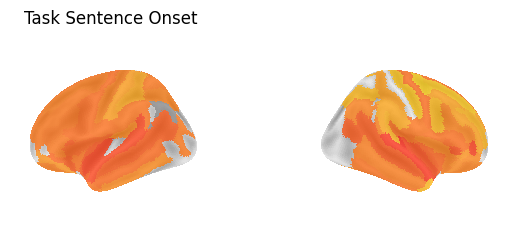

left max: 0.0
left max: -1.9197799763952283
right max: 0.0


/tmp/ipykernel_2438424/1556765441.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


left max: 0.0
left max: -2.64479928018103
right max: 0.0


/tmp/ipykernel_2438424/1556765441.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


left max: 0.0
left max: -3.903186891689072
right max: 0.0


/tmp/ipykernel_2438424/1556765441.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


left max: 0.0
left max: -4.440249631397995
right max: 0.0


/tmp/ipykernel_2438424/1556765441.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


left max: 0.0
left max: -1.2691787907118668
right max: 0.0


/tmp/ipykernel_2438424/1556765441.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


left max: 0.0
left max: -4.444780808634586
right max: 0.0


/tmp/ipykernel_2438424/1556765441.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


left max: 0.0
left max: -2.1414626329484303
right max: 0.0


/tmp/ipykernel_2438424/1556765441.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


left max: 0.0
left max: -3.0365189111551754
right max: 0.0


/tmp/ipykernel_2438424/1556765441.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


left max: 0.0
left max: -2.078735623748816
right max: 0.0


/tmp/ipykernel_2438424/1556765441.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


left max: 0.0
left max: -1.6846892964865612
right max: 0.0


/tmp/ipykernel_2438424/1556765441.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


left max: 0.0
left max: -2.2371188443178087
right max: 0.0


/tmp/ipykernel_2438424/1556765441.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


left max: 0.0
left max: -3.5442117566086986
right max: 0.0


/tmp/ipykernel_2438424/1556765441.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


left max: 0.0
left max: -3.2883807749960283
right max: 0.0


/tmp/ipykernel_2438424/1556765441.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


left max: 0.0
left max: -3.7687805713580587
right max: 0.0


/tmp/ipykernel_2438424/1556765441.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


left max: 0.0
left max: -3.854184043709282
right max: 0.0


/tmp/ipykernel_2438424/1556765441.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


left max: 0.0
left max: -4.281768357840057
right max: 0.0


/tmp/ipykernel_2438424/1556765441.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


left max: 0.0
left max: -2.783185914433331
right max: 0.0


/tmp/ipykernel_2438424/1556765441.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


left max: 0.0
left max: -3.9169947472360667
right max: 0.0


/tmp/ipykernel_2438424/1556765441.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


<Figure size 640x480 with 0 Axes>

In [216]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(40, 12))

lower = 0.51
epsilon = 1e-4
scale = lambda x: (np.log(max((x - lower), epsilon)))

lower = 0.51
inverse_scale = lambda x: np.exp(x) + lower

num_cols = 5
num_rows = 4
outer = gridspec.GridSpec(num_rows, num_cols, wspace=0.2, hspace=0.2)

# Loop through each subplot and add a simple plot or title
for i in range(num_rows):
    for j in range(num_cols):
        # Index in outer grid
        outer_idx = i * num_cols + j

        # if i*num_cols+j >= num_rows*num_cols - 1:
        if i*num_cols+j >= 19:
            ax = fig.add_subplot(outer[num_rows*num_cols - 1])

            cmap = grey_to_red  # You can choose any colormap
            norm = mcolors.Normalize(vmin=scale(lower), vmax=scale(0.7))  # Colorbar from 0 to 100
            
            # Create a ScalarMappable and initialize a colorbar
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])  # required for compatibility with the colorbar
            
            # Add colorbar to the figure
            cbar = fig.colorbar(sm, cax=ax, orientation='horizontal')
            cbar.set_label('Value (%)')
            
            cbar.ax.set_position([0.77,0.17,0.10,0.025])  # or use cbar.ax.set_position([...]) for fine-tuning
            cbar.ax.tick_params(labelsize=25)
            cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda val, pos: f"{inverse_scale(val):.02}"))
            cbar.set_label("ROC-AUC (log scale)", fontsize=25)
            # ax.set_axis_off()
            continue
            
        # Define inner 2x1 grid within this cell
        inner = gridspec.GridSpecFromSubplotSpec(
            1, 2, subplot_spec=outer[outer_idx], hspace=0.1
        )
            
        task = task_order[i*num_cols+j]
        ax1 = fig.add_subplot(inner[0], projection='3d')
        ax2 = fig.add_subplot(inner[1], projection='3d')
        # ax1.plot([1])
        axes =  [ax1, ax2]
        sc = plot_task(task, axes)
        # break
    # break
plt.tight_layout()

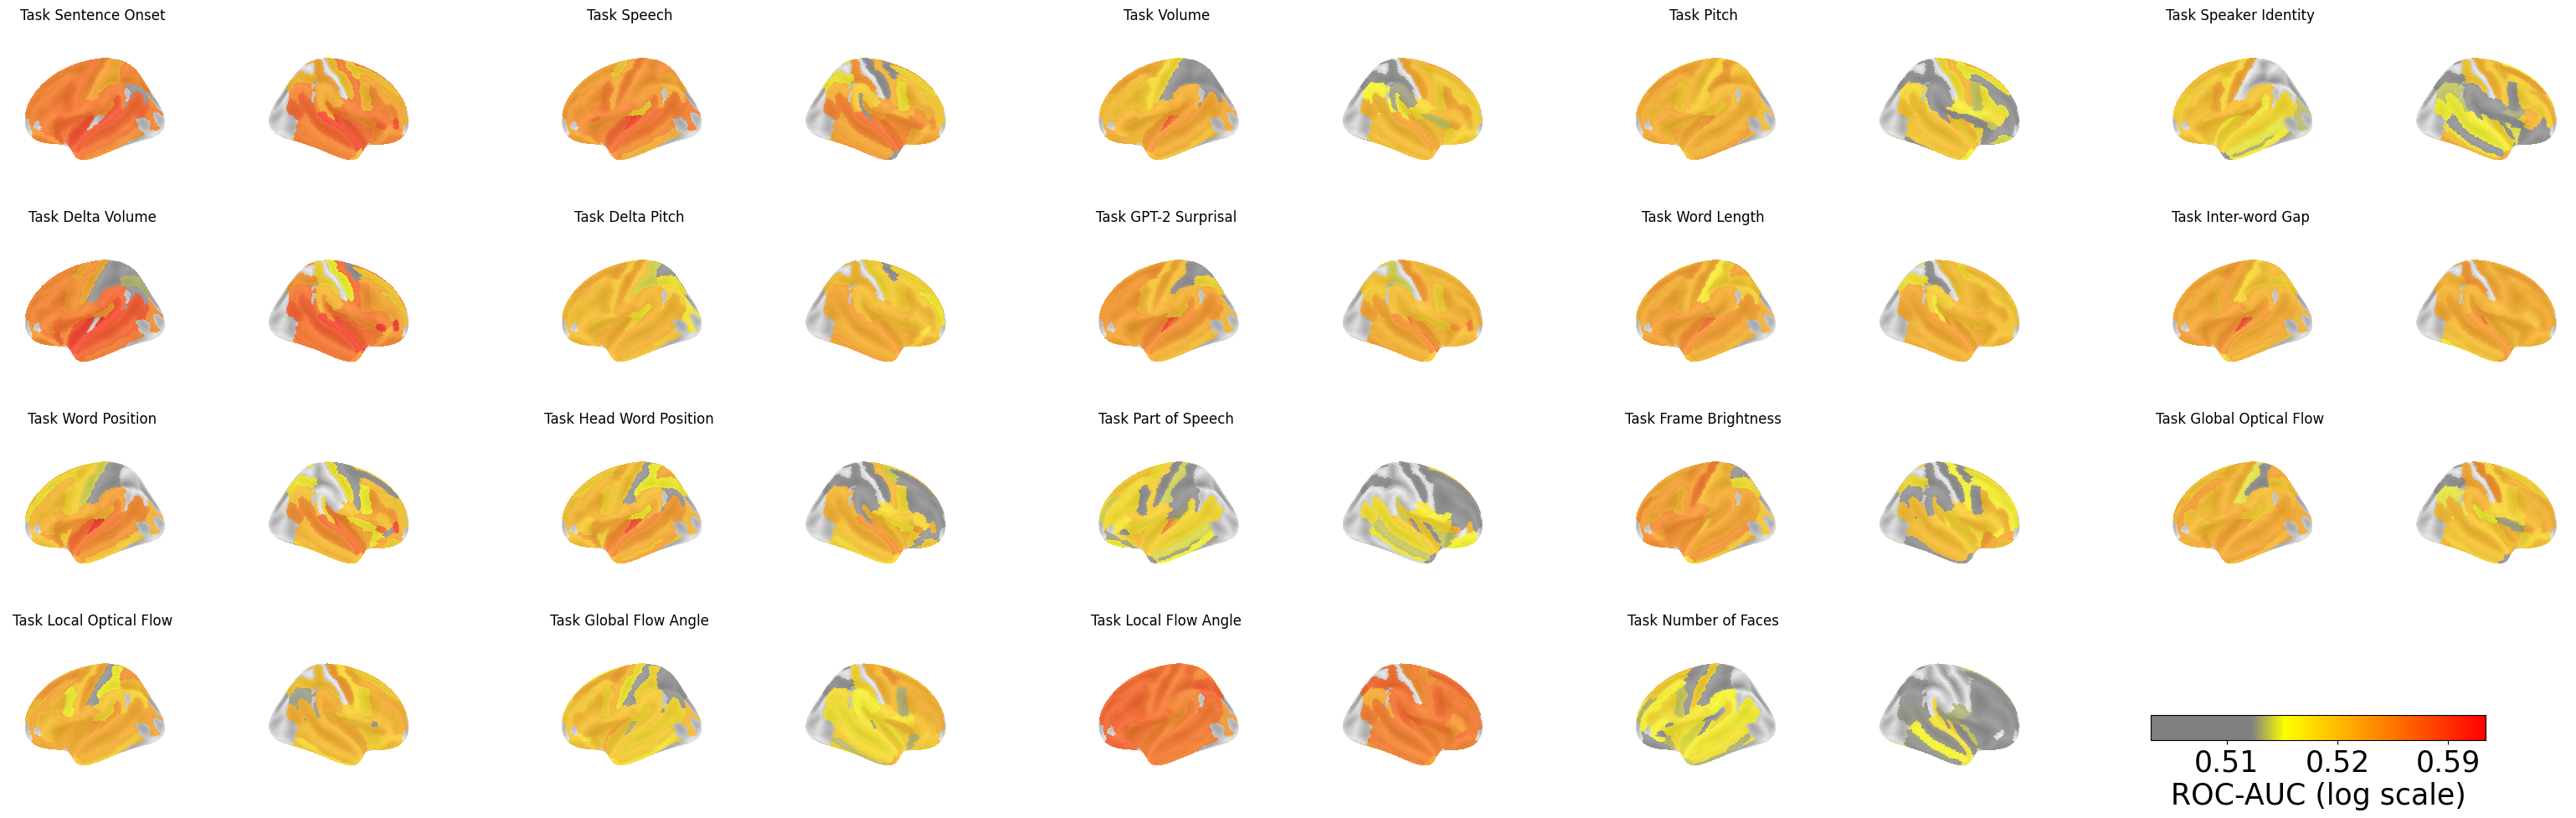

In [217]:
fig

In [218]:
# axes[0].view_init
inverse_scale(0.7)

np.float64(2.523752707470477)

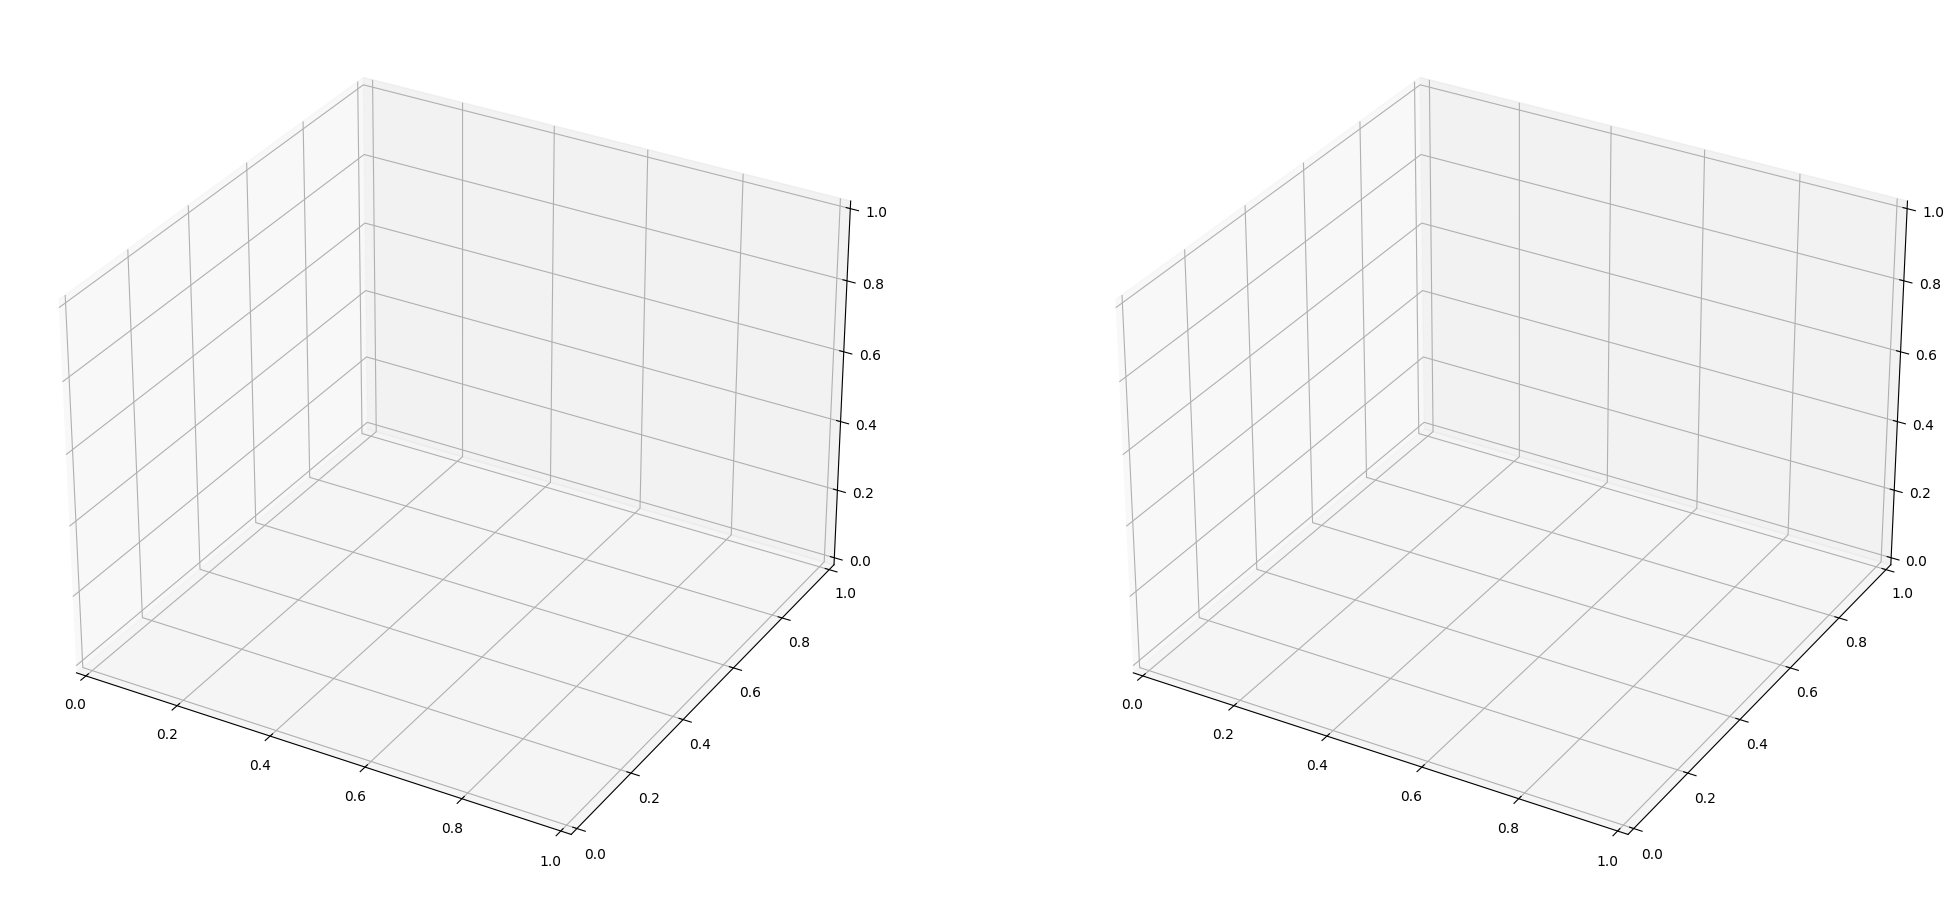

In [219]:
fig, axes = plt.subplots(1,2,figsize=(25, 25), subplot_kw={'projection': '3d'})


In [33]:
axes[0]

<Axes3D: >

In [ ]:
plot_surf_roi(fsaverage['inflated'], roi_map=left_results_parcellation,
                    hemi='left', view='lateral',
                    bg_map=fsaverage_sulcal, bg_on_data=True,
                    darkness=.5, cmap="Reds", vmin=0.48, vmax=0.6,
                    # darkness=.5, cmap="Reds",
                    axes=axes[0])


# get stats

In [71]:
task = "gpt2_surprisal"
task_results = localization_merged_df[localization_merged_df.task==task].dropna()

task_results.groupby("Destrieux").mean("avg_test").sort_values(by="avg_test")

,avg_test,time_bin,L,I,P,ShiftDist,ConfType,Hemisphere
Destrieux,,,,,,,,
ctx_lh_S_cingul-Marginalis,0.493340,0.3125,152.000000,82.000000,158.000000,0.000000,0.000000,0.0
ctx_lh_S_intrapariet_and_P_trans,0.495860,0.3125,163.142857,90.857143,175.571429,0.626201,0.000000,0.0
ctx_lh_S_postcentral,0.498320,0.3125,170.571429,86.571429,159.428571,0.335856,0.000000,0.0
ctx_lh_G_and_S_cingul-Mid-Post,0.499322,0.3125,134.153846,87.846154,133.615385,0.829662,0.153846,0.0
ctx_lh_G_parietal_sup,0.499336,0.3125,171.000000,82.000000,176.000000,0.974909,0.000000,0.0
...,...,...,...,...,...,...,...,...
ctx_lh_G_temp_sup-Lateral,0.510768,0.3125,182.299065,112.822430,133.850467,0.308802,0.467290,0.0
ctx_rh_G_temp_sup-Plan_polar,0.513832,0.3125,79.615385,125.211538,116.596154,0.393901,0.000000,1.0
ctx_rh_S_temporal_transverse,0.517122,0.3125,74.000000,110.500000,137.000000,1.102553,0.000000,1.0


In [110]:
task_results[(task_results.time_bin==0.5) & (task_results.Destrieux.str.contains("front") & (task_results.Hemisphere==0))].groupby("Destrieux").mean("avg_test").sort_values(by="avg_test")

,avg_test,time_bin,L,I,P,ShiftDist,ConfType,Hemisphere
Destrieux,,,,,,,,
ctx_lh_G_front_inf-Orbital,0.505950,0.5,164.478261,115.608696,86.956522,0.138081,0.260870,0.0
ctx_lh_G_front_sup,0.507083,0.5,139.253731,75.597015,106.507463,0.375844,0.029851,0.0
ctx_lh_S_front_middle,0.508568,0.5,153.863636,91.750000,84.363636,0.888328,0.000000,0.0
ctx_lh_S_front_inf,0.508615,0.5,161.758621,92.896552,96.344828,1.030818,0.000000,0.0
ctx_lh_G_front_inf-Triangul,0.509002,0.5,172.458824,109.682353,92.505882,0.151175,0.611765,0.0
ctx_lh_S_front_sup,0.510298,0.5,148.270270,76.216216,93.270270,0.592156,0.378378,0.0
ctx_lh_G_front_inf-Opercular,0.512538,0.5,176.217949,103.602564,109.884615,0.226765,0.461538,0.0
ctx_lh_G_front_middle,0.515960,0.5,163.158537,83.317073,93.707317,0.322251,0.073171,0.0


In [118]:
region = "ctx_lh_G_front_middle"
time = -0.125
task_results[(task_results.time_bin==time) & (task_results.Destrieux==region)].sort_values(by="avg_test")[-100:]['avg_test'].mean()

np.float64(0.5021154139275027)

In [90]:
# task_results[(task_results.time_bin==0.5)].sort_values

,subject,trial,ID,electrode,avg_test,time_bin,task,Electrode,L,I,P,DesikanKilliany,Destrieux,DKT,ShiftDist,ConfType,Subject,region_common_name,common_name,Hemisphere
22828,6,0,F3aOFa1-sub_6,F3aOFa1,0.469842,0.5,gpt2_surprisal,F3aOFa1,131.0,118.0,63.0,ctx-lh-medialorbitofrontal,ctx_lh_G_rectus,ctx-lh-medialorbitofrontal,0.000000,1.0,sub_6,Frontal,medial orbitofrontal,0.0
22842,6,0,F3aOFa2-sub_6,F3aOFa2,0.497371,0.5,gpt2_surprisal,F3aOFa2,135.0,117.0,64.0,ctx-lh-medialorbitofrontal,ctx_lh_G_rectus,ctx-lh-medialorbitofrontal,0.000000,1.0,sub_6,Frontal,medial orbitofrontal,0.0
22856,6,0,F3aOFa3-sub_6,F3aOFa3,0.485597,0.5,gpt2_surprisal,F3aOFa3,137.0,117.0,66.0,ctx-lh-lateralorbitofrontal,ctx_lh_G_orbital,ctx-lh-lateralorbitofrontal,1.339944,0.0,sub_6,Frontal,lateral orbitofrontal,0.0
22870,6,0,F3aOFa4-sub_6,F3aOFa4,0.472556,0.5,gpt2_surprisal,F3aOFa4,140.0,115.0,68.0,ctx-lh-lateralorbitofrontal,ctx_lh_G_orbital,ctx-lh-lateralorbitofrontal,0.822936,0.0,sub_6,Frontal,lateral orbitofrontal,0.0
22884,6,0,F3aOFa5-sub_6,F3aOFa5,0.499632,0.5,gpt2_surprisal,F3aOFa5,145.0,114.0,69.0,ctx-lh-lateralorbitofrontal,ctx_lh_G_orbital,ctx-lh-lateralorbitofrontal,0.000000,0.0,sub_6,Frontal,lateral orbitofrontal,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004582,3,0,O1bId12-sub_3,O1bId12,0.496931,0.5,gpt2_surprisal,O1bId12,173.0,104.0,179.0,ctx-lh-inferiorparietal,ctx_lh_S_temporal_sup,ctx-lh-inferiorparietal,0.000000,0.0,sub_3,Parietal,inferior parietal,0.0
1004596,3,0,O1bId13-sub_3,O1bId13,0.522989,0.5,gpt2_surprisal,O1bId13,174.0,102.0,182.0,ctx-lh-inferiorparietal,ctx_lh_S_temporal_sup,ctx-lh-inferiorparietal,0.000000,0.0,sub_3,Parietal,inferior parietal,0.0
1004610,3,0,O1bId14-sub_3,O1bId14,0.511730,0.5,gpt2_surprisal,O1bId14,174.0,101.0,185.0,ctx-lh-inferiorparietal,ctx_lh_S_temporal_sup,ctx-lh-inferiorparietal,0.000000,0.0,sub_3,Parietal,inferior parietal,0.0
1004624,3,0,O1bId15-sub_3,O1bId15,0.498439,0.5,gpt2_surprisal,O1bId15,174.0,100.0,188.0,ctx-lh-inferiorparietal,ctx_lh_G_occipital_middle,ctx-lh-inferiorparietal,0.000000,0.0,sub_3,Parietal,inferior parietal,0.0
